<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Итак, сначала загрузим все необходимое. 

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'
!Rscript -e 'install.packages("tidyverse")'

In [ ]:
import rpy2.robjects as ro
ro.r('BiocManager::install("glmGamPoi")')

In [ ]:
%%R

suppressPackageStartupMessages({
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(MASS)
  library(DESeq2)
  library(tidyverse)  
})

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
!pip3 install gseapy==0.10.8
!gdown "1saZcoMgLnhM-U9qZTKVVh5_y8nKdufH5&confirm=t"
!wget https://raw.githubusercontent.com/BostonGene/MFP/master/signatures/gene_signatures.gmt

In [ ]:
!gdown "1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg&confirm=t
To: /content/LUAD_counts.tsv
100% 3.18M/3.18M [00:00<00:00, 222MB/s]


Откроем табличку, уберем от туда повторы.

In [ ]:
%%R -o df_c
df_counts <- read.csv("LUAD_counts.tsv", sep = '\t', row.names=NULL)
df_c <- df_counts %>% distinct(gene_name, .keep_all = TRUE)
df_c <- data.frame(df_c, row.names = 1)

In [ ]:
df_c.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39
TSPAN6,4275,1536,5009,1889,1329,1194,1443,783,2492,2366,...,1919,2624,2257,2721,5817,4473,3868,1546,7846,3825
TNMD,0,0,13,0,0,1,0,0,2,1,...,0,0,0,0,1,0,3,1,0,0
DPM1,1071,765,2731,1941,1395,1812,1275,783,3880,2760,...,2082,1964,644,1993,1664,2253,1718,1563,2104,1177
SCYL3,630,510,919,548,297,489,230,380,1100,807,...,899,431,538,824,754,1465,1126,975,922,400
C1orf112,542,172,321,301,320,617,104,72,204,1011,...,262,198,212,461,605,348,450,145,268,449


Создадим еще одну таблицу с соотнесением образца и группы, к которой он относится.

In [ ]:
df = pd.read_csv("LUAD_tpms.tsv", sep="\t", index_col=0)
signatures = {}

with open("gene_signatures.gmt") as f:
  for line in f.readlines():
    signatures[line.split("\t")[0]] = line.strip().split("\t")[2:]
    
import gseapy as gp

ss = gp.ssgsea(
    data=df,
    gene_sets=signatures.copy(),
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA = ss.res2d

Creating directory /root/.config/bioservices 


2022-12-07 06:42:54,785 Warning: dropping duplicated gene names, only keep the first values


In [ ]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

labels = ["low_immune" if i == 1 else "immune" for i in hierarchy.fcluster(
  hierarchy.linkage(distance.pdist(ssGSEA.T), method="average"),
  t=2,
  criterion="maxclust"
)]

In [ ]:
%%R -i labels
df1 <- data.frame(id = colnames(df_c),
                 group = labels)
df1 <- data.frame(df1, row.names = 1)
head(df1)

              group
sample_0 low_immune
sample_1     immune
sample_2     immune
sample_3     immune
sample_4     immune
sample_5     immune


Для DESeq2 все готово, можно выполнять дифференциальную экспрессию

In [ ]:
%%R
dds<-DESeqDataSetFromMatrix(countData = df_c, 
                       colData = df1,
                       design =  ~ group)

In [ ]:
%%R
dds

class: DESeqDataSet 
dim: 19938 40 
metadata(1): version
assays(1): counts
rownames(19938): TSPAN6 TNMD ... AL391628.1 AP006621.6
rowData names(0):
colnames(40): sample_0 sample_1 ... sample_38 sample_39
colData names(1): group


In [ ]:
%%R
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep, ]

In [ ]:
%%R
dds$group <- relevel(dds$group, ref = 'immune')

In [ ]:
%%R
dds <- DESeq(dds)
res <- results(dds)







-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





Посмотрим, все ли получилось

In [ ]:
%%R
res

log2 fold change (MLE): group low immune vs immune 
Wald test p-value: group low immune vs immune 
DataFrame with 18166 rows and 8 columns
             baseMean log2FoldChange     lfcSE      stat    pvalue      padj
            <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
TSPAN6     2806.89446       0.347132  0.217613   1.59518  0.110673  0.248699
TNMD          1.27163       0.386722  0.869546   0.44474  0.656508  0.789496
DPM1       1535.87796      -0.142258  0.135393  -1.05071  0.293393  0.478823
SCYL3       685.42866       0.153954  0.124836   1.23325  0.217482  0.393661
C1orf112    333.47077      -0.258361  0.236844  -1.09085  0.275340  0.460211
...               ...            ...       ...       ...       ...       ...
AC013477.1   2.009587       0.798747  0.583926  1.367891  0.171346 0.3353813
AC010980.1  37.752002      -1.141543  0.497555 -2.294304  0.021773 0.0786179
AC004233.4   0.828978      -0.372671  0.878761 -0.424088  0.671502 0.7995320
AL391628.1   6

Да, все нормально, поэтому сделаем две таблички для GSEA с сортировкой по logFC (rank1) и по —logFDR со знаком logFC (rank2)

In [ ]:
%%R -o res
res$sign_lfc <- sign(res$log2FoldChange)
res <- res[!(is.na(res$padj)), ]
res$s_padj <- res$padj * res$sign_lfc

In [ ]:
%%R -o res

res1 <- res[order(res$log2FoldChange),]
res2 <- res[order(res$s_padj), ]

In [ ]:
%%R -o rank1
# res1$SYMBOL <- rownames(res1)
rank1 <- data.frame(SYMBOL = rownames(res1),
 log2FoldChange = res1$log2FoldChange)


In [ ]:
%%R -o rank2
# res1$SYMBOL <- rownames(res1)
rank2 <- data.frame(SYMBOL = rownames(res2),
 s_padj = res2$s_padj)

In [ ]:
rank1

,SYMBOL,log2FoldChange
1,SALL1,-5.555978
2,SSX1,-4.848137
3,TBX20,-4.843420
4,CALML5,-4.809326
5,FOXE1,-4.717581
...,...,...
18162,PCSK1,5.600581
18163,MUC5AC,5.679430
18164,PAX7,5.849351
18165,SST,6.414333


In [ ]:
rank2

,SYMBOL,s_padj
1,BOLL,-0.999914
2,RNF170,-0.999911
3,NAA25,-0.999742
4,MND1,-0.999742
5,CAPN3,-0.999611
...,...,...
18162,RBP4,0.999742
18163,DENND1B,0.999769
18164,TPRG1L,0.999801
18165,TARM1,0.999914


Сначала запустим gsea.prerank с rank1. 
(https://gseapy.readthedocs.io/en/master/gseapy_example.html#3.-Prerank-example)

In [ ]:
pre_res = gp.prerank(rnk=rank1, 
                     gene_sets=signatures.copy(),
                     min_size=3,
                     permutation_num=1000,
                     outdir=None, 
                     verbose=True,
                    )

In [ ]:
pre_res.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Coactivation_molecules,-0.846342,-2.063196,0.000000,0.000000,14,14,ICOSLG;TNFSF9;TNFRSF4;CD83;CD27;CD70;CD80;CD40...,CD83;CD27;CD70;CD80;CD40;TNFSF4;CD28;CD86;CD40...
Effector_cells,-0.890668,-2.046875,0.000000,0.000000,12,12,GNLY;ZAP70;GZMB;EOMES;TBX21;CD8B;GZMA;CD8A;PRF...,ZAP70;GZMB;EOMES;TBX21;CD8B;GZMA;CD8A;PRF1;GZM...
NK_cells,-0.843458,-2.125133,0.000000,0.000000,17,17,FGFBP2;GNLY;KLRF1;CD160;KLRK1;KLRC2;GZMB;EOMES...,KLRF1;CD160;KLRK1;KLRC2;GZMB;EOMES;NCR3;KIR2DL...
T_cells,-0.945548,-1.965760,0.000000,0.000000,11,8,CD28;CD3D;CD5;CD3E;ITK;TBX21;CD3G;TRAT1,CD28;CD3D;CD5;CD3E;ITK;TBX21;CD3G;TRAT1
Macrophage_DC_traffic,-0.893014,-1.892748,0.000000,0.000238,8,8,XCL1;CSF1;CSF1R;XCR1;CCL2;CCR2;CCL7;CCL8,CSF1;CSF1R;XCR1;CCL2;CCR2;CCL7;CCL8
T_cell_traffic,-0.887104,-1.893467,0.000000,0.000278,9,9,CX3CL1;CXCR3;CX3CR1;CCL3;CCL4;CCL5;CXCL10;CXCL...,CXCR3;CX3CR1;CCL3;CCL4;CCL5;CXCL10;CXCL11;CXCL9
CAF,-0.751124,-1.943321,0.000000,0.000334,19,19,MFAP5;CD248;PDGFRB;ACTA2;COL5A1;MMP2;COL6A1;LU...,PDGFRB;ACTA2;COL5A1;MMP2;COL6A1;LUM;COL1A2;COL...
Macrophages,-0.893902,-1.879279,0.001650,0.000626,8,8,CD68;SIGLEC1;IL10;CSF1R;MRC1;CD163;MSR1;IL4I1,CD68;SIGLEC1;IL10;CSF1R;MRC1;CD163;MSR1;IL4I1
Checkpoint_inhibition,-0.841886,-1.855409,0.000000,0.000927,9,9,LAG3;VSIR;CTLA4;HAVCR2;TIGIT;BTLA;PDCD1;PDCD1L...,VSIR;CTLA4;HAVCR2;TIGIT;BTLA;PDCD1;PDCD1LG2;CD274


Если сравнивать с таблицей, которая получилась на семинаре, то в целом оно конечно не прям такое же, но похоже. 
Построим gseaplot для первого и второго набора, раз уж их положение в таблице совпало с тем, что было на семинаре.

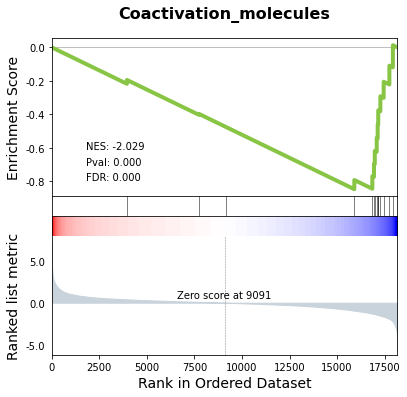

In [ ]:
from gseapy import gseaplot, heatmap

group = "Coactivation_molecules"
gseaplot(pre_res.ranking, term=group, **pre_res.results[group])

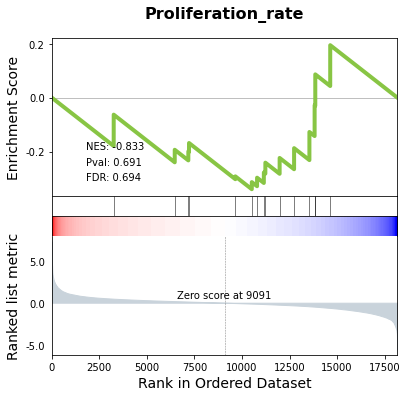

In [ ]:
group = "Proliferation_rate"
gseaplot(pre_res  .ranking, term=group, **pre_res.results[group])

Штош, действительно похоже на то, что было

Теперь повторим все для rank2

In [ ]:
pre_res_2 = gp.prerank(rnk=rank2, 
                     gene_sets=signatures.copy(),
                     min_size=3,
                     permutation_num=1000,
                     outdir=None, 
                     verbose=True,
                    )

In [ ]:
pre_res_2.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Macrophage_DC_traffic,-0.937916,-2.013472,0.000000,0.000000,8,8,CCL2;CCR2;CSF1R;CSF1;CCL8;XCR1;CCL7;XCL1,XCL1
MHCI,-0.776380,-1.648630,0.008163,0.062943,8,8,TAP1;B2M;TAP2;NLRC5;HLA-B;HLA-C;TAPBP;HLA-A,TAPBP;HLA-A
Effector_cells,-0.693312,-1.679803,0.004264,0.066264,12,12,FASLG;CD8A;GZMA;PRF1;TBX21;CD8B;GZMK;IFNG;EOME...,GNLY
Treg,-0.821503,-1.705655,0.004040,0.068718,7,7,IL10;CCR8;CTLA4;FOXP3;IKZF2;TNFRSF18;IKZF4,TNFRSF18;IKZF4
T_cell_traffic,-0.752319,-1.655673,0.016194,0.069988,9,9,CXCL9;CCL5;CXCL10;CCL4;CXCL11;CCL3;CXCR3;CX3CR...,CX3CL1
NK_cells,-0.637194,-1.729005,0.006452,0.077957,17,17,CD226;NKG7;GZMH;CD244;NCR1;IFNG;EOMES;SH2D1B;N...,KLRF1;GNLY;FGFBP2
EMT_signature,0.781451,1.610560,0.016227,0.082916,7,7,CDH2;ZEB2;SNAI2;ZEB1;TWIST2;SNAI1;TWIST1,CDH2
CAF,-0.593260,-1.584906,0.020161,0.096518,19,19,FGF2;CXCL12;LRP1;PDGFRA;FBLN1;COL6A2;COL6A3;FA...,COL6A1;PDGFRB;LUM;ACTA2;MMP2;COL1A2;MMP3;COL1A...
MDSC_traffic,-0.600569,-1.538004,0.034000,0.098399,15,15,CSF3R;CSF1R;CXCL12;CSF2RA;CSF1;CCL26;CSF3;IL6;...,CSF2;CCL15;CXCL5;IL6R


В данном случае все совсем по-другому получается. Ну gseaplot, которые ниже, тоже соответсвенно абсолютно по-другому выглядят

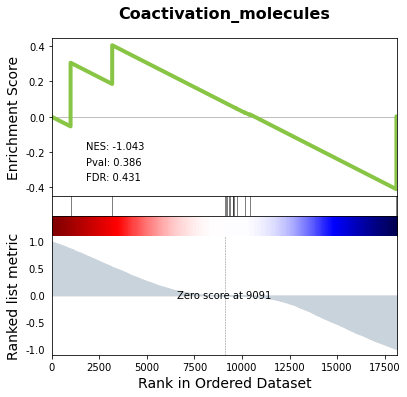

In [ ]:
group = "Coactivation_molecules"
gseaplot(pre_res_2.ranking, term=group, **pre_res_2.results[group])

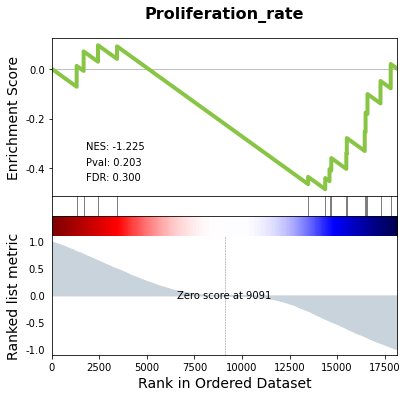

In [ ]:
group = "Proliferation_rate"
gseaplot(pre_res_2.ranking, term=group, **pre_res_2.results[group])